# Grado en Ingeniería de Tecnologías y Servicios de Telecomunicación / Grado en Ingeniería Informática
### **Asignatura**: Tratamiento de Señales Visuales/Tratamiento de Señales Multimedia I
### Práctica 4: Reconocimiento de escenas con Deep Learning

---

Autor: Juan C. SanMiguel (juancarlos.sanmiguel@uam.es), Universidad Autónoma de Madrid


# Entrenamiento red neuronal convolucional


En este script interativo de python aprenderá a entrenar utilizando la API de alto nivel [Keras](https://www.tensorflow.org/api_docs/python/tf/keras) disponible para Tensorflow

Tiempo estimado para completar este script: 35 minutos

# 1.Preparación del entorno de trabajo

A continuación tiene un conjunto de instrucciones para establecer el entorno de trabajo y descargar el dataset.

* Verifique que la versión de Python es >3.6 y la versión de Tensorflow es 2.3.0

* Adicionalmente procedemos a la descarga del dataset [Scenes15](http://www-vpu.eps.uam.es/~jcs/pub/scenes15.zip)  completo sin ninguna partición.

In [1]:
#%%capture
#%tensorflow_version 2.x
!pip install tensorflow==2.3.0
import tensorflow as tf
import os, subprocess
!python --version                     # mostrar version de python
print('Tensorflow ' + tf.__version__) # mostrar version tensorflow

     |████████████████████████████████| 320.4 MB 45 kB/s 
     |████████████████████████████████| 2.9 MB 34.5 MB/s 
     |████████████████████████████████| 20.1 MB 61.8 MB/s 
     |████████████████████████████████| 459 kB 43.8 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.7.0
    Uninstalling tensorflow-estimator-2.7.0:
      Successfully uninstalled tensorflow-estimator-2.7.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Attempting uninstall: gast
    Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Successfully uninstalled gast-0.4.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.7.0
    Uninstalling tensorflow-2.7.0:


Python 3.7.12
Tensorflow 2.3.0


In [2]:
import os, subprocess

# Montar Google Drive y crear carpetas
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

work_dir = '/content/work_dir'                    # directorio de trabajo en local (mas rapido)
dwld_dir = '/content/gdrive/My Drive/dwld_dir'    # directorio de descarga en Google drive personal
subprocess.call(["mkdir","-p",work_dir])          # crear directorio para trabajo
subprocess.call(["mkdir","-p",dwld_dir+'/dataset/'])  # crear directorio para dataset

os.chdir(dwld_dir+'/dataset/')                        # posicionarse en el directorio
# Descargar dataset scenes15 si no esta disponible
if os.path.isfile('./dataset_scenes15.zip') == False: 
  !wget http://www-vpu.eps.uam.es/~jcs/tsv/dataset_scenes15.zip 
  
# Copiar el dataset al directorio local (mayor velocidad de lectura que en Gdrive)
!cp /content/gdrive/My\ Drive/dwld_dir/dataset/dataset_scenes15.zip /content/work_dir/

os.chdir(work_dir)                        # posicionarse en el directorio
if os.path.isdir('./scenes15') == False: 
  !unzip -o -q dataset_scenes15.zip -d .

print('El dataset se encuentra descargado en el directorio {} \ny descomprimido en el directorio {} (usado para lectura de datos)'.format(dwld_dir, work_dir))

Mounted at /content/gdrive
El dataset se encuentra descargado en el directorio /content/gdrive/My Drive/dwld_dir 
y descomprimido en el directorio /content/work_dir (usado para lectura de datos)


# 2.Seleccionar Hardware
Antes de comenzar el entrenamiento, debemos seleccionar que recursos hardware queremos utilizar para realizar los cálculos. 

Tensorflow permite ejecutar nuestras instrucciones utilizando la CPU (Central Processing Unit) y la GPU (Graphics Processing Unit). Para redes con múltiples capas, se recomienda utilizar la GPU por su alta capacidad de paralelización.

Con el siguiente código puede ver los recursos disponibles y seleccionar el hardware:

In [3]:
import tensorflow as tf
import time

print("Num CPUs disponibles: ", len(tf.config.experimental.list_physical_devices('CPU')))
print("Num GPUs disponibles: ", len(tf.config.experimental.list_physical_devices('GPU')))

time1 = time.time() # medida de tiempo

# ejecutar en CPU
with tf.device('/CPU:0'):
  random_image_cpu = tf.random.normal((100, 100, 100, 3))
  net_cpu = tf.keras.layers.Conv2D(128, 7)(random_image_cpu)

time2 = time.time() # medida de tiempo

# ejecutar en GPU
with tf.device('/device:GPU:0'):
  random_image_cpu = tf.random.normal((100, 100, 100, 3))
  net_cpu = tf.keras.layers.Conv2D(128, 7)(random_image_cpu)

time3 = time.time() # medida de tiempo
print('Tiempo ejecución CPU {} secs y GPU {} secs' .format(time2-time1, time3-time2))
print('Ejecute varias veces este bloque de código pues la primera vez no observará diferencias debido a que se deben inicializar los registros para la CPU y GPU')

Num CPUs disponibles:  1
Num GPUs disponibles:  1
Tiempo ejecución CPU 1.743623971939087 secs y GPU 3.056006669998169 secs
Ejecute varias veces este bloque de código pues la primera vez no observará diferencias debido a que se deben inicializar los registros para la CPU y GPU


# 3.Crear iterador para los datos del dataset
El siguiente paso es obtener un iterador sobre los datos del dataset. Como ya se ha visto anteriormente, utilizaremos la funcionalidad ```tf.keras.preprocessing.image.ImageDataGenerator``` [documentación](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)

In [4]:
import tensorflow as tf
import pathlib
import numpy as np

dataset_dir = pathlib.Path(work_dir + '/scenes15/')

# Obtener etiquetas de clase y numero de clases
CLASS_NAMES = np.array([item.name for item in dataset_dir.glob('*')]) #clases son subdirectorios de '/train/'
NUM_CLASSES = len(CLASS_NAMES) # numero total de clases
 
# Crear ImageDataGenerator convirtiendo de uint8 a float32 en el rango [0,1].
img_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split=0.20)

# Obtenemos un iterador sobre los datos de entrenamiento del dataset
# aplicando el ImageDataGenerator creado anteriormente
BATCH_SIZE = 16 # numero de elementos procesados conjuntamente en cada iteracion
IMG_HEIGHT = 32
IMG_WIDTH = 32
IMG_CHANNELS = 3
train_data_gen = img_gen.flow_from_directory(directory=str(dataset_dir),
                                          target_size=(IMG_HEIGHT, IMG_WIDTH),
                                          color_mode='rgb',                                                     
                                          classes = list(CLASS_NAMES),
                                          class_mode='categorical',
                                          batch_size=BATCH_SIZE, 
                                          subset="training",                                         
                                          shuffle=True,
                                          seed=0)

test_data_gen = img_gen.flow_from_directory(directory=str(dataset_dir),
                                          target_size=(IMG_HEIGHT, IMG_WIDTH),
                                          color_mode='rgb',                                                     
                                          classes = list(CLASS_NAMES),
                                          class_mode='categorical',
                                          batch_size=BATCH_SIZE,
                                          subset="validation",
                                          shuffle=True,
                                          seed=0)


Found 3592 images belonging to 15 classes.
Found 893 images belonging to 15 classes.


# 4.Definir red 
Posteriormente definimos la red utilizando la funcionalidad ```tensorflow.keras.model``` [[documentación]](https://www.tensorflow.org/api_docs/python/tf/keras/Model) y la funcionalidad ```tf.keras.layers``` [documentación](https://www.tensorflow.org/api_docs/python/tf/keras/layers), descrita anteriormente.

In [5]:
import tensorflow.keras.layers as layers
import tensorflow.keras.models as models

# definir modelo de red
model = models.Sequential()

# incluir capa convolucional C1
model.add(layers.Conv2D(filters=6, 
                        kernel_size=(3, 3), 
                        strides = (1,1),
                        padding = 'valid',
                        activation='relu', 
                        input_shape=(IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS)))

# incluir average pooling S2
model.add(layers.AveragePooling2D())

# incluir capa convolucional C3
model.add(layers.Conv2D(filters=16, 
                        kernel_size=(3, 3),
                        strides = (1,1),
                        padding = 'valid', 
                        activation='relu'))

# incluir average pooling S4
model.add(layers.AveragePooling2D())

# convertir el volumen de datos en vector fila para conectarlo con capa FC
model.add(layers.Flatten())

# incluir fully convolutional F5
model.add(layers.Dense(units=120, activation='relu'))

# incluir fully convolutional F6
model.add(layers.Dense(units=84, activation='relu'))

# incluir salida OUTPUT
model.add(layers.Dense(units=NUM_CLASSES, activation = 'softmax'))


# mostar resumen
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 30, 30, 6)         168       
_________________________________________________________________
average_pooling2d (AveragePo (None, 15, 15, 6)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 16)        880       
_________________________________________________________________
average_pooling2d_1 (Average (None, 6, 6, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 576)               0         
_________________________________________________________________
dense (Dense)                (None, 120)               69240     
_________________________________________________________________
dense_1 (Dense)              (None, 84)                1

#5.Definir parámetros de optimización
La siguiente etapa consiste en detallar los parámetros que van a definir la optimización a realizar.

Para esta tarea utilizaremos la funcionalidad ```tensorflow.keras.model``` [[documentación]](https://www.tensorflow.org/api_docs/python/tf/keras/Model) y en concreto el método ```tensorflow.keras.model.compile``` [[documentacion]](https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile)

El método ```tensorflow.keras.model.compile``` tiene los siguientes argumentos principales:
* **optimizer**: string que indica el nombre del optimizado seleccionado (que se utilizará con valores por defecto).  También puede ser un objeto optimizador con valores específicos. Puede consultar la lista de optimizadores disponibles [[aquí]](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers).

* **loss**: string que indica el tipo de función objetivo a utilizar. Puede consultar la lista de opciones disponibles [[aquí]](https://www.tensorflow.org/api_docs/python/tf/losses).
* **metrics**: lista de métricas para evaluar el modelo durante entrenamiento y test.

A continuación se muestra un ejemplo para definir estos parámetros.





In [6]:
import tensorflow.keras.optimizers as optimizers

# definicion con optimizador con valores definidos por el usuario
LEARNING_RATE = 0.01 # factor de aprendizaje
model.compile(optimizer=optimizers.SGD(lr=LEARNING_RATE),            
            loss='categorical_crossentropy',            
            metrics=['accuracy'])

# 6.Ejecución del entrenamiento
Finalmente, procedemos a realizar el entrenamiento utilizando la funcionalidad ```tensorflow.keras.model``` [[documentación]](https://www.tensorflow.org/api_docs/python/tf/keras/Model) y en concreto el método ```tensorflow.keras.model.fit_generator``` [[documentacion]](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit_generator). 


Adicionalmente, este método permite definir un conjunto de validación que se evalua al terminar cada época. En este caso utilizaremos el conjunto de test que nos permitirá comprender mejor el proceso de entrenamiento.

El tiempo estimado para completar el entrenamiento con EPOCHS=10 es ~70 secs (GPU) y ~100 secs (CPU).

In [7]:
import time
stime = time.time() # medida inicial de tiempo

EPOCHS = 10 # numero de epocas para entrenamiento

#si tiene problemas al ejecutar con la GPU, 
# descomente la siguiente linea para utilizar la CPU
# y comente la linea que selecciona la GPU
#with tf.device('/CPU:0'):
with tf.device('/GPU:0'):
  history = model.fit_generator(
      generator=train_data_gen,          
      steps_per_epoch=train_data_gen.n // BATCH_SIZE,      
      validation_data=test_data_gen,
      validation_steps=test_data_gen.n // BATCH_SIZE,
      epochs=EPOCHS,
      verbose=1     
  )  
      
ftime = time.time() # medida final de tiempo
print('Entrenamiento terminado {} secs' .format(ftime-stime))

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
224/224 [==============================] - 6s 27ms/step - loss: 2.6911 - accuracy: 0.0881 - val_loss: 2.6811 - val_accuracy: 0.0989
Epoch 2/10
224/224 [==============================] - 6s 26ms/step - loss: 2.6465 - accuracy: 0.1158 - val_loss: 2.6341 - val_accuracy: 0.1159
Epoch 3/10
224/224 [==============================] - 5s 24ms/step - loss: 2.5787 - accuracy: 0.1454 - val_loss: 2.6409 - val_accuracy: 0.1057
Epoch 4/10
224/224 [==============================] - 6s 27ms/step - loss: 2.5183 - accuracy: 0.1770 - val_loss: 2.5861 - val_accuracy: 0.1341
Epoch 5/10
224/224 [==============================] - 6s 27ms/step - loss: 2.4704 - accuracy: 0.1840 - val_loss: 2.6102 - val_accuracy: 0.1364
Epoch 6/10
224/224 [==============================] - 6s 28ms/step - loss: 2.4286 - accuracy: 0.2061 - val_loss: 2.5250 - val_accuracy: 0.1773
Epoch 7/10
224/224 [==============================] - 5s 22ms/step

#7.Ejecucion de test
Para evaluar los datos de test, también utilizaremos la funcionalidad ```tensorflow.keras.model``` [[documentación]](https://www.tensorflow.org/api_docs/python/tf/keras/Model) y en concreto el método ```tensorflow.keras.model.evaluate_generator``` [[documentacion]](https://www.tensorflow.org/api_docs/python/tf/keras/Model#evaluate_generator). 

El tiempo estimado para completar el test es de ~8 secs (GPU). Este método es muy sencillo de utilizar:


In [8]:
import time
stime = time.time() # medida inicial de tiempo

#si tiene problemas al ejecutar con la GPU, 
# descomente la siguiente linea para utilizar la CPU
# y comente la linea que selecciona la GPU
#with tf.device('/CPU:0'):
with tf.device('/GPU:0'):
  test_loss, test_acc = model.evaluate_generator(generator=test_data_gen, 
                                                 steps = test_data_gen.n // BATCH_SIZE, 
                                                 verbose=1)
  
ftime = time.time() # medida final de tiempo
print('Test terminado {} secs' .format(ftime-stime))

Instructions for updating:
Please use Model.evaluate, which supports generators.
55/55 [==============================] - 1s 20ms/step - loss: 2.3970 - accuracy: 0.2375
Test terminado 1.2217564582824707 secs


#8.Visualización de resultados

Para visualizar los resultados de cada época de manera grafica, utilizaremos el paquete ```matplotlib.pyplot```

Primeramente extraemos los resultados del proceso de entrenamiento, que hemos almacenado en la variable `history` devuelta por la función 
`model.fit_generator`

In [9]:
# rendimiento
acc = history.history['accuracy']         #entrenamiento
val_acc = history.history['val_accuracy'] #validacion

# funcion de perdidas
loss = history.history['loss']            #entrenamiento
val_loss = history.history['val_loss']    #validacion

Después pintamos los resultados:

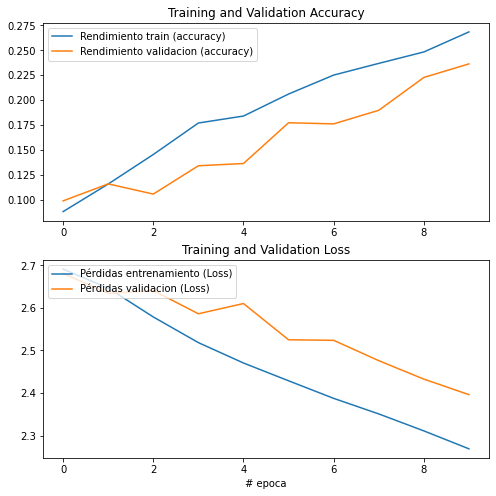

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.subplot(2,1, 1)
plt.plot(range(EPOCHS), acc, label='Rendimiento train (accuracy)')
plt.plot(range(EPOCHS), val_acc, label='Rendimiento validacion (accuracy)')
plt.legend(loc='upper left')
plt.title('Training and Validation Accuracy')

plt.subplot(2,1, 2)
plt.plot(range(EPOCHS), loss, label='Pérdidas entrenamiento (Loss)')
plt.plot(range(EPOCHS), val_loss, label='Pérdidas validacion (Loss)')
plt.legend(loc='upper left')
plt.title('Training and Validation Loss')
plt.xlabel('# epoca')

plt.show()

#9.Guardar resultados
En esta última sección, le mostraremos como puede guardar resultados:

In [11]:
#guardar el modelo de red obtenido
#https://www.tensorflow.org/api_docs/python/tf/keras/Model
#https://www.tensorflow.org/tutorials/keras/save_and_load
os.chdir(dwld_dir)  
save_dir = dwld_dir + '/my_models'
subprocess.call(["mkdir","-p",save_dir])  # crear directorio para guardar modelo
model.save(
    save_dir,
    overwrite=True,
    include_optimizer=True,
)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/dwld_dir/my_models/assets


#10. Probar otros tamaños de épocas

In [13]:

def todo_el_proceso(EPOCHS = 30):
  stime = time.time() # medida inicial de tiempo


  #si tiene problemas al ejecutar con la GPU, 
  # descomente la siguiente linea para utilizar la CPU
  # y comente la linea que selecciona la GPU
  #with tf.device('/CPU:0'):
  with tf.device('/GPU:0'):
    history = model.fit_generator(
        generator=train_data_gen,          
        steps_per_epoch=train_data_gen.n // BATCH_SIZE,      
        validation_data=test_data_gen,
        validation_steps=test_data_gen.n // BATCH_SIZE,
        epochs=EPOCHS,
        verbose=1     
    )  
        
  ftime = time.time() # medida final de tiempo
  print('Entrenamiento terminado {} secs' .format(ftime-stime))

  stime = time.time() # medida inicial de tiempo

  #si tiene problemas al ejecutar con la GPU, 
  # descomente la siguiente linea para utilizar la CPU
  # y comente la linea que selecciona la GPU
  #with tf.device('/CPU:0'):
  with tf.device('/GPU:0'):
    test_loss, test_acc = model.evaluate_generator(generator=test_data_gen, 
                                                  steps = test_data_gen.n // BATCH_SIZE, 
                                                  verbose=1)
    
  ftime = time.time() # medida final de tiempo
  print('Test terminado {} secs' .format(ftime-stime))
  
  
  # rendimiento
  acc = history.history['accuracy']         #entrenamiento
  val_acc = history.history['val_accuracy'] #validacion

  # funcion de perdidas
  loss = history.history['loss']            #entrenamiento
  val_loss = history.history['val_loss']    #validacion

  plt.figure(figsize=(8, 8))
  plt.subplot(2,1, 1)
  plt.plot(range(EPOCHS), acc, label='Rendimiento train (accuracy)')
  plt.plot(range(EPOCHS), val_acc, label='Rendimiento validacion (accuracy)')
  plt.legend(loc='upper left')
  plt.title('Training and Validation Accuracy')

  plt.subplot(2,1, 2)
  plt.plot(range(EPOCHS), loss, label='Pérdidas entrenamiento (Loss)')
  plt.plot(range(EPOCHS), val_loss, label='Pérdidas validacion (Loss)')
  plt.legend(loc='upper left')
  plt.title('Training and Validation Loss')
  plt.xlabel('# epoca')

  plt.show()

Epoch 1/30
224/224 [==============================] - 6s 29ms/step - loss: 2.2306 - accuracy: 0.2791 - val_loss: 2.4306 - val_accuracy: 0.2398
Epoch 2/30
224/224 [==============================] - 6s 28ms/step - loss: 2.2028 - accuracy: 0.2796 - val_loss: 2.4283 - val_accuracy: 0.2330
Epoch 3/30
224/224 [==============================] - 5s 23ms/step - loss: 2.1629 - accuracy: 0.3015 - val_loss: 2.3574 - val_accuracy: 0.2500
Epoch 4/30
224/224 [==============================] - 6s 28ms/step - loss: 2.1247 - accuracy: 0.3154 - val_loss: 2.2848 - val_accuracy: 0.2841
Epoch 5/30
224/224 [==============================] - 6s 28ms/step - loss: 2.0797 - accuracy: 0.3241 - val_loss: 2.3397 - val_accuracy: 0.2580
Epoch 6/30
224/224 [==============================] - 6s 28ms/step - loss: 2.0367 - accuracy: 0.3378 - val_loss: 2.3049 - val_accuracy: 0.2705
Epoch 7/30
224/224 [==============================] - 6s 28ms/step - loss: 1.9914 - accuracy: 0.3563 - val_loss: 2.2787 - val_accuracy: 0.2773

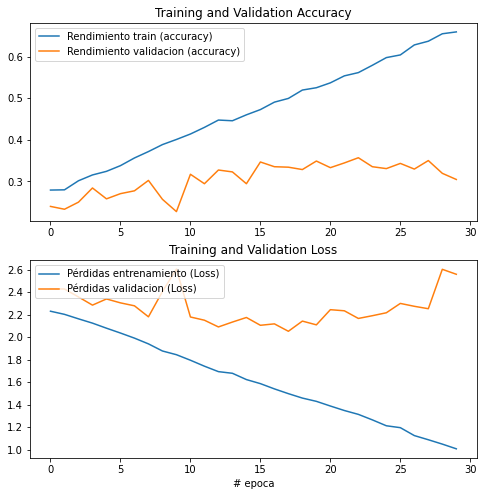

In [14]:
todo_el_proceso(EPOCHS = 30)

En el caso de 30 épocas tenemos overfitting al final ya que la puntuación no aumenta a partir de 25 épocas, de hecho empeora.

Epoch 1/50
224/224 [==============================] - 5s 23ms/step - loss: 0.9666 - accuracy: 0.6823 - val_loss: 2.3621 - val_accuracy: 0.3625
Epoch 2/50
224/224 [==============================] - 6s 28ms/step - loss: 0.9365 - accuracy: 0.6874 - val_loss: 2.6185 - val_accuracy: 0.3341
Epoch 3/50
224/224 [==============================] - 6s 27ms/step - loss: 0.8828 - accuracy: 0.7078 - val_loss: 2.4804 - val_accuracy: 0.3500
Epoch 4/50
224/224 [==============================] - 6s 27ms/step - loss: 0.8279 - accuracy: 0.7271 - val_loss: 2.7582 - val_accuracy: 0.3091
Epoch 5/50
224/224 [==============================] - 6s 27ms/step - loss: 0.8081 - accuracy: 0.7332 - val_loss: 2.6447 - val_accuracy: 0.3352
Epoch 6/50
224/224 [==============================] - 6s 28ms/step - loss: 0.7469 - accuracy: 0.7478 - val_loss: 2.8084 - val_accuracy: 0.3239
Epoch 7/50
224/224 [==============================] - 6s 28ms/step - loss: 0.7096 - accuracy: 0.7581 - val_loss: 2.8860 - val_accuracy: 0.3375

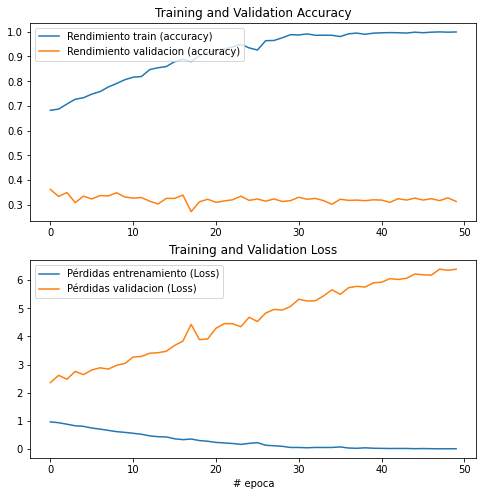

In [15]:
todo_el_proceso(EPOCHS = 50)

Este ejemplo es aún más claro de como incurre en overfitting, cuando el dataset de entrenamiento esta consiguiendo prácticamente puntuación máxima el de validación va empeorando, en la gráfica de loss se puede observar un compartimiento muy similar.